## Author: Tiana Wei

Due date: 2020/11/25

The purpose of this assignment is to compute the sentiment of text information - in our case, tweets posted recently on US Presidential Elections 2020 - and answer the research question: **“What can public opinion on Twitter tell us about the US political landscape in 2020?”** The goal is to essentially **use sentiment analysis on Twitter data to get insight into the 2020 American Elections**.

In [1]:
# install needed libraries
!pip install nltk
!pip install wordcloud
!pip install openpyxl

In [2]:
## load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
import nltk
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import openpyxl

## 1. Data cleaning (20 marks)

o All html tags and attributes (i.e., /<[^>]+>/) are removed.

o Html character codes (i.e., &...;) are replaced with an ASCII equivalent.

o All URLs are removed.

o All characters in the text are in lowercase.

o All stop words are removed. Be clear in what you consider as a stop word.

o If a tweet is empty after pre-processing, it should be preserved as such.

In [3]:
# read the two csv files
elect = pd.read_csv("US_Elections_2020.csv")
senti = pd.read_csv("sentiment_analysis.csv")

In [4]:
# create empty columns for tokenized words later
elect['words'] = ""
elect['hashtags'] = ""
senti['words'] = ""
senti['hashtags'] = ""

In [5]:
import re
import string

def clean_data(df):
    """
    This function cleans the tweet text with the following steps
    1. remove line breaks and URLs
    2. tokenize words and hashtags
    3. remove punctuation tokens
    4. convert to lower case
    5. remove stop words
    7. assign stings to the 'words' column of the input dataframe
    8. assign strings to the 'hashtags' column of the input dataframe
    """
    # take the text column and loop through each row
    for i in range(len(df)):
        text = str(df['text'][i])
    
        # remove line breaks and dots
        text = text.replace('\\n',' ')
    
        # remove URLs
        text = re.sub(r"http\S+", "", text)
        
    
        # TweetTokenizer from nltk library can tokenize tweet-related units like user handles and hashtags
        twtok = TweetTokenizer(strip_handles=True) # remove user handles
    
        # tokenize words and hashtags
        tokens = list(twtok.tokenize(text))
    
        # remove punctuations
        punctuations = list(string.punctuation) + ['..', '...']
        tokens = [tok for tok in tokens if not tok in punctuations]
    
        # convert to lower case
        tokens = [w.lower() for w in tokens]
    
        ## remove stop words that do not contribute to deeper meaning of the sentence
        # read in stop_word list provided
        file = open("stop_words.txt",'rt')
        stopWords = file.read().split('\n')
        file.close()

        # append 'b' and 'rt' to the list of stop words since they do not add meaning to the tweet
        stopWords.extend(["b","rt","b'rt","b'"])

        # remove stop words
        tokens = [tok for tok in tokens if not tok in stopWords]
        
        # take all hashtags
        hashtags = [tok for tok in tokens if tok.startswith('#') == True]
        
        # a column for tokens
        df.at[i,'words'] = tokens
        
        # a column for hashtags
        df.at[i,'hashtags'] = hashtags
    
    

In [6]:
# use the above defined function to clean the election-related tweets
clean_data(elect)

In [7]:
elect.head()

,text,sentiment,negative_reason,words,hashtags
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19,"[afraid, nov, dec, jan, #bidenharris2020, win,...",[#bidenharris2020]
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others,"[lord, sumption, launches, recovery, initiativ...","[#anotherway, #covid]"
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19,"[uber, timing, #biden, advisors, pressure, #br...","[#biden, #brazil]"
3,b'Every 107 seconds an American is dying from ...,1,NaN,"[b'every, 107, seconds, american, dying, #trum...","[#trumpvirus, #donaldtrump, #joebiden]"
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN,"[#democrats, embrace, #diversityandinclusion, ...","[#democrats, #diversityandinclusion, #vote]"


In [8]:
## THIS CELL TAKES TIME TO RUN ##

# use the above defined function to clean the generic tweet data
clean_data(senti)

In [ ]:
senti.head()

,ID,text,label,words,hashtags
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,"[josh, jenkins, forward, tab, breeders, crown,...",[]
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,"[congratulations, pakistan, #no1testteam, odds...","[#no1testteam, #ji_pakzindabadrallies]"
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,"[september, maine, mendoza, ’, surprise, thank...",[]
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,"[newly, painted, walls, custodial, painters, s...",[#ec_proud]
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,"[excited, july, 2017, feschotte, lab, will, re...",[]


## 2. Exploratory analysis (15 marks)


### Part 1:
o Design a simple procedure that **determines the political party (Republican Party,
Democratic Party and Others) of a given tweet** and apply this procedure to all the tweets
in the **2020 US elections dataset**. A suggestion would be to look at relevant words and
hashtags in the tweets that identify to certain political parties or candidates. **What can
you say about the distribution of the political affiliations of the tweets?**


### We can take two step to make the political party classification more accurate:

(1) Look at the combination of the overall sentiment assiged to the tweet and the specific party-related words mentioned in the tweet
    
    - PROS: can help classify tweets without hashtags
    - CONS: can be rather inaccurate. Many negative sentiment tweet mentioning Biden actually supports Biden and many positive sentiment tweet mentioning Trump actually disapprove Trump.


(2) Look at the hashtags + the sentiment of the hashtags

    - PROS: hashtags included in the text are more direct indices of the political party. can be more accurate.
    - CONS: need to identify them rather manually for accuracy.
    
    e.g.,
    A tweet with positive Trump-related hashtags or a tweet with negative Biden-related hashtags -> Republican Party.
    A tweet with positive Biden-related hashtags or a tweet with negative Trump-related hashtags -> Democratic Party.
    If under neither condition above, categorize as others.


Note: I am classifying tweets to political parties according to their political support instead of the mere mentioning of the political party. I prefer this way of classification since we can easily visualize the number of support one political party has with the party label regardless of sentiment.

In [9]:
# look at all the hashtags we have from all tweets
hashtag_list = []
for i in range(len(elect)):
    hashtag = [tag for tag in elect['hashtags'][i] if not tag in hashtag_list]
    hashtag_list.extend(hashtag)
# look at 5 examples
hashtag_list[0:5]

['#bidenharris2020', '#anotherway', '#covid', '#biden', '#brazil']

In [10]:
# specify a few key words to democrat and republic
D = ['biden','democrat','blue']
R = ['trump','republic','red']

In [11]:
## first, classify tweets into democrate and republican based on keywords mentioned in text and the sentiment classification

# create a new column to assign political party
elect['party'] = "Others"

for i in range(len(elect)):
    for k in D:
        for w in elect['words'][i]:
            if (k in w) and (elect['sentiment'][i] == 1):
                elect.loc[i, 'party'] = 'Democratic'
            elif (k in w) and (elect['sentiment'][i] == 0):
                elect.loc[i, 'party'] = 'Republican'

                
for i in range(len(elect)):
    for k in R:
        for w in elect['words'][i]:
            if (k in w) and (elect['sentiment'][i] == 1):
                elect.loc[i, 'party'] = 'Republican'
            elif (k in w) and (elect['sentiment'][i] == 0):
                elect.loc[i, 'party'] = 'Democratic'
        

In [12]:
# based on the keywords, separate hashtags into democrat and republic
D_tag = []
R_tag = []

for key in D:
    for tag in hashtag_list:
        if key in tag:
            D_tag.append(tag)
            
for key in R:
    for tag in hashtag_list:
        if key in tag:
            R_tag.append(tag)

In [13]:
## identify hashtags mentioning each party that are **actually negative**

D_neg = ['#nobiden','#corruptjoebiden','#crookedjoebiden','#bidencorruption','#bidencrimefamiiy','hunterbiden','#hunterbidenemails',
        '#hunterbidenlaptop','#hunterbidenpedo','#bidencrimefamiily','#bidencrimefamiy','#lyinhidenbiden',
        '#bidendementia','#lyingbiden','#sleepyjoebiden','#chinajoebiden','#democratsaredestroyingamerica',
        '#walkawayfromdemocrats','#democratsarecorrupt','#democratsareevil']

R_neg = ['#trumpvirus','#trumpcrimefamily','#trumpslaststand','#trumpknew','#trumpiscompromised','#trumppandemic',
        '#trumpforprison','#trumpforprison','#votetrumpout','#dumptrump2020','#americaortrump',
         '#trumpknewanddidnothing','#trumpkillsamericans','#trumpliesmatter','#lockuptrump','#superspreadertrump',
        '#trumpism','#trumpislosing','#trumpisnotamerica','#trumpliesamericansdie','#trumpcollapse','#thetrumpshow',
         '#trumpvirusdeathtoll232k','#trumpisaloser','#voteagainsttrump','#trumpliespeopledie','#dumptrump',
         '#potustrump','#notrump','#trumpsdeadlysins','#impeachtrump','#trumpvirusdeathtoll227k','#trumpsucks',
         '#resignnowtrump','#trumpwontknow','#trumpcorruption','#trumpgaveup','#impeachedtrump','#nevertrump',
        '#trumpderangementsyndrome','#traitortrump','#trumpgenocideforprofit','#trump-elstiltskin','#trumpisputinsbitch',
         '#ivankatrump','#dumpthetrump','#trumpispathetic','#dumptrumpdaynov3','#trumplies','#trumpisanationaldisgrace',
         '#trumpisunwell','#trumpviruscatastrophe','#trumpisawarcriminal','#trumpspreadslieshatefearcovid','#trumpsters',
         '#trumpslie']

In [14]:
# classify tweets according to hashtag mentions
for i in range(len(elect)):
    for tag in elect['hashtags'][i]:
        if tag in D_tag:
            elect.loc[i, 'party'] = 'Democratic'
        elif tag in R_tag:
            elect.loc[i, 'party'] = 'Republican'
      
    
# **RE-classify** tweets if they have negative hashtag mentions
for i in range(len(elect)):
    for tag in elect['hashtags'][i]:
        if tag in D_neg:
            elect.loc[i, 'party'] = 'Republican'
        elif tag in R_neg:
            elect.loc[i, 'party'] = 'Democratic'


In [15]:
elect.head()

,text,sentiment,negative_reason,words,hashtags,party
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19,"[afraid, nov, dec, jan, #bidenharris2020, win,...",[#bidenharris2020],Democratic
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others,"[lord, sumption, launches, recovery, initiativ...","[#anotherway, #covid]",Others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19,"[uber, timing, #biden, advisors, pressure, #br...","[#biden, #brazil]",Democratic
3,b'Every 107 seconds an American is dying from ...,1,NaN,"[b'every, 107, seconds, american, dying, #trum...","[#trumpvirus, #donaldtrump, #joebiden]",Democratic
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN,"[#democrats, embrace, #diversityandinclusion, ...","[#democrats, #diversityandinclusion, #vote]",Democratic


Now that we has assigned the political party to each tweet, let's visualize the distribution of the tweets in supporting the two parties.

In [16]:
elect.groupby('party').size()

party
Democratic     903
Others        1250
Republican     399
dtype: int64

Text(0.5, 1.0, 'Number of tweets supporting each political party')

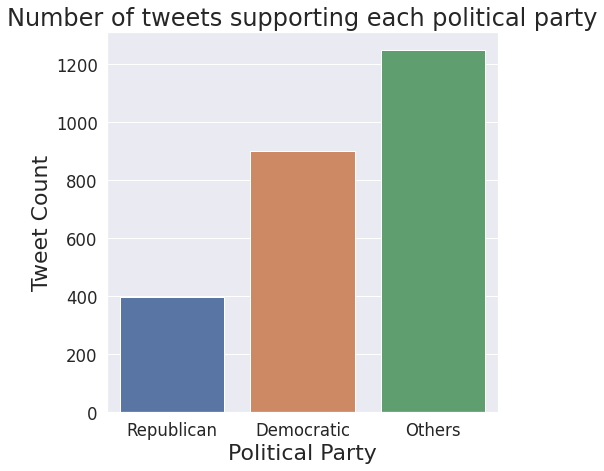

In [17]:
# plot tweet counts for each party
plt.figure(figsize=(7,7))
sns.set(font_scale = 1.5)
sns.countplot(x = 'party', data=elect, order=['Republican','Democratic','Others'])
plt.xlabel("Political Party",size = 22)
plt.ylabel("Tweet Count",size = 22)
plt.title("Number of tweets supporting each political party", size=24)

From the above plot for the tweet distriution supporting each party, we can see that:

(1) The number of tweets supporting the Democratic party is more than twice of the number of tweets supporting the Republican party. Based on this simple exploration, one can predict Biden winning the 2020 election, which turned out to be correct.

(2) Many tweets are categorized as others, which include tweets not mentioning the keywords specified. These tweets most likely did not express clear political stands.

### Part 2:

o Present **a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc) that
visualizes some aspect of the generic tweets in sentiment_analysis.csv** and **another
figure for the 2020 US election tweets**. All graphs and plots should be readable and
have all axes that are appropriately labelled.

In [ ]:
senti.head()

,ID,text,label,words,hashtags
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1,"[josh, jenkins, forward, tab, breeders, crown,...",[]
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,"[congratulations, pakistan, #no1testteam, odds...","[#no1testteam, #ji_pakzindabadrallies]"
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1,"[september, maine, mendoza, ’, surprise, thank...",[]
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,"[newly, painted, walls, custodial, painters, s...",[#ec_proud]
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1,"[excited, july, 2017, feschotte, lab, will, re...",[]


In [ ]:
# join all words in the generic tweets as text to feed in wordcloud later
generic_words = ''

for i in range(len(senti)):
    generic_words += " ".join(senti['words'][i]) + " "


In [ ]:
## plot wordcloud with the size of the word reflecting the Word Frequency in the generic tweet data
# WordCloud default max_word = 200 -> show the most frequent 200 words
generic_wordcloud = WordCloud(width = 800, height = 800,background_color='black', 
                      colormap='Set2', collocations=False,min_font_size = 10).generate(generic_words)

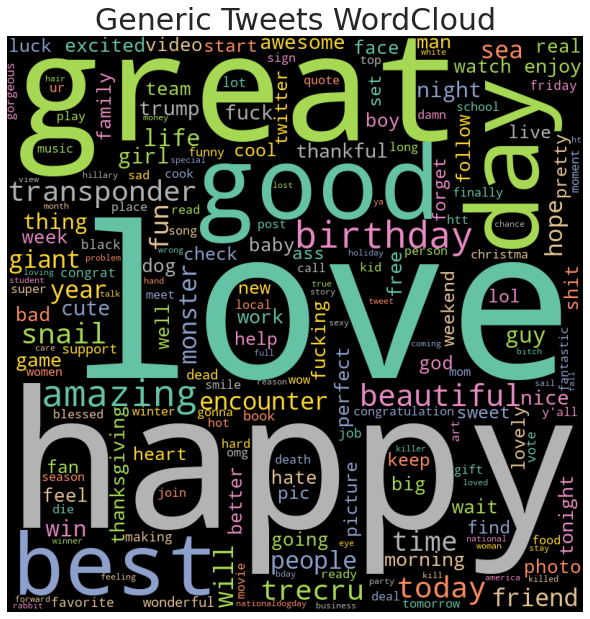

In [ ]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(generic_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Generic Tweets WordCloud", size=30)
  
plt.show() 

From the word cloud for the generic tweet data, we can see that the most frequent content words in the tweets is "love", followed by some other frequent words like happy, amazing, great, ... etc. The generic tweet data seems pretty positive based on the word frequency shown on the wordcloud :).

Now, let's take a look at the US election-related tweets.

In [ ]:
# join all words in the generic tweets as text to feed in wordcloud later
elect_words = ''

for i in range(len(elect)):
    elect_words += " ".join(elect['words'][i]) + " "


In [ ]:
## plot wordcloud with the size of the word reflecting the Word Frequency in the generic tweet data
# WordCloud default max_word = 200 -> show the most frequent 200 words
election_wordcloud = WordCloud(width = 800, height = 800,background_color='black', 
                      colormap='Set2', collocations=False,min_font_size = 10).generate(elect_words)

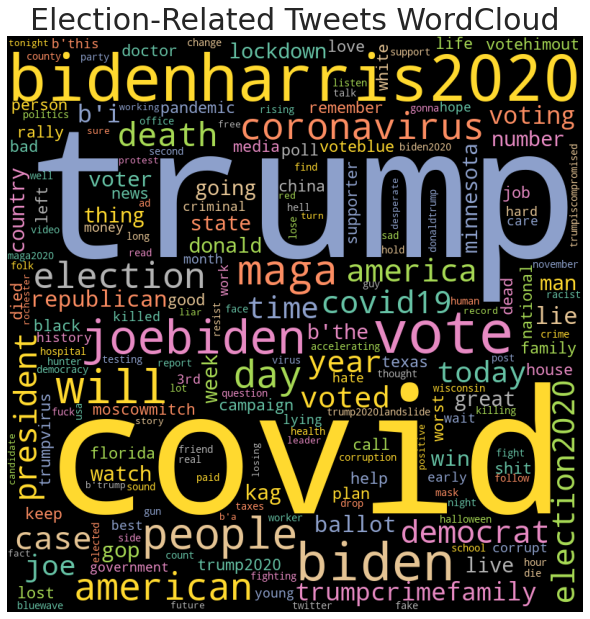

In [ ]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(election_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Election-Related Tweets WordCloud", size = 30)
  
plt.show() 

From the wordcloud for the US election tweets, we can see that the most frequent words are "trump" and "covid", followed by some other frequent words/terms like "vote", "biden", "bidenharris2020", ... etc. 

It is interesting to see that "trump" is the most mentioned word but not a lot of people actually supports Trump based on the political party analysis in Q1. It implies that a lot of tweets were most likely criticizing Trump. 

### **Bonus** exploration

We can look at the proportion of positive and negative sentiment tweets in each political party.

Text(0.5, 1.0, 'Sentiment of tweets supporting each political party')

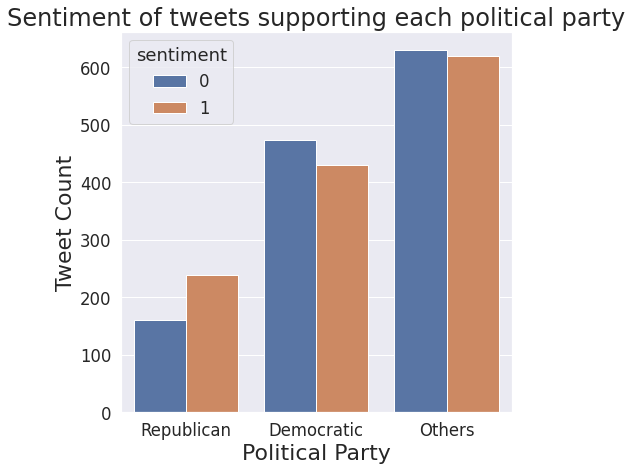

In [ ]:
# plot tweet counts for each party separated by sentiment
plt.figure(figsize=(7,7))
sns.set(font_scale = 1.5)
sns.countplot(x = 'party', hue='sentiment',data=elect,order=['Republican','Democratic','Others'])
plt.xlabel("Political Party",size = 22)
plt.ylabel("Tweet Count",size = 22)
plt.title("Sentiment of tweets supporting each political party", size=24)

We can see that:

(1) Tweets that are categorized as Republican supporters are mostly showing political support by saying something positive about the Republican party. 

(2) On the other hand, tweets that are categorized as Democrat supporters are mostly showing political support by criticizing the Republican party. 

-> I can infer this since I categorized negative tweets mentioning Republican-related words as Democratic supporters.

# 3. Model preparation (15 marks)

Split the generic tweets randomly into training data (70%) and test data (30%). Prepare the data to try multiple **classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF, XGBoost))**, where each tweet is considered
a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, **Bag of Words (word frequency)** and **TF-IDF**. 

(Hint: Be careful about when to split the dataset into training and testing set)

In [21]:
# import libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

## Bag of Words

Simply calculate word frequency in the given corpus.

In [22]:
corpus = []

for i in range(len(senti)):
    corpus.append(" ".join(senti['words'][i]))

In [23]:
# assign X and Y variables
X = corpus
Y = list(senti['label'])

In [24]:
# split x and y var into train and test
# spliting train and test set before vectorization so that the test set would be unseen
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [25]:
# select only the top 10000 words to reduce run time
vectorizer = CountVectorizer(max_features = 10000)

In [26]:
# build the bags of words on tain and test set
X_train_wf = vectorizer.fit_transform(X_train)
X_test_wf = vectorizer.transform(X_test)

In [27]:
X_train_wf

<385273x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 1884211 stored elements in Compressed Sparse Row format>

In [28]:
X_test_wf

<165118x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 804327 stored elements in Compressed Sparse Row format>

In [29]:
print('Vocabulary Size: {}'.format(len(vectorizer.vocabulary_)))

Vocabulary Size: 10000


## TF-IDF

Term Frequency-Inverse Document Frequency basically tells importance of the word in the corpus or dataset. TF-IDF contain two concept Term Frequency(TF) and Inverse Document Frequency(IDF).

Term Frequency is defined as how frequently the word appear in the document or corpus. As each sentence is not the same length so it may be possible a word appears in long sentence occur more time as compared to word appear in sorter sentence. 

Inverse Document frequency is another concept which is used for finding out importance of the word. It is based on the fact that less frequent words are more informative and important. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [ ]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,1),max_features=10000)

In [ ]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Logistic Regression

In [ ]:
# increase max_iter so that the _coef can converge
logreg = LogisticRegression(solver = 'lbfgs', max_iter=1000)

In [ ]:
scores = cross_val_score(logreg, X_train_wf, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.95


Bag of words features

In [ ]:
# fit logistic regression model to training data
logreg.fit(X_train_wf, y_train)
# look at accuracy of the model on training and test sets
print("Training set score: {:.3f}".format(logreg.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_wf, y_test)))

Training set score: 0.960
Test set score: 0.953


In [ ]:
pred_logreg = logreg.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_logreg)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_logreg,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 50268   3455]
 [  4312 107083]]
              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93     53723
    Positive       0.97      0.96      0.97    111395

    accuracy                           0.95    165118
   macro avg       0.94      0.95      0.95    165118
weighted avg       0.95      0.95      0.95    165118



In [ ]:
accuracy_score(y_test,pred_logreg)

0.9529609128017539

TF-IDF features

In [ ]:
# fit logistic regression model to training data
logreg.fit(X_train_tfidf, y_train)
# look at accuracy of the model on training and test sets
print("Training set score: {:.3f}".format(logreg.score(X_train_tfidf, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_tfidf, y_test)))

Training set score: 0.958
Test set score: 0.953


In [ ]:
pred_logreg_tfidf = logreg.predict(X_test_tfidf)
confusion = confusion_matrix(y_test,pred_logreg_tfidf)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_logreg_tfidf,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 50091   3632]
 [  4137 107258]]
              precision    recall  f1-score   support

    Negative       0.92      0.93      0.93     53723
    Positive       0.97      0.96      0.97    111395

    accuracy                           0.95    165118
   macro avg       0.95      0.95      0.95    165118
weighted avg       0.95      0.95      0.95    165118



In [ ]:
accuracy_score(y_test,pred_logreg_tfidf)

0.9529488002519411

### k-Nearest-Neighbors (k-NN)

k-NN models work by taking a data point and looking at the ‘k’ closest labeled data points. The data point is then assigned the label of the majority of the ‘k’ closest points.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# set model
#While there are various distance calculations between neighbors to use, I will
#use the euclidean since it is the default. Also, as a rule of thumb, number of
#neighbors used initially should be the sqrt(number of training data)
knn = KNeighborsClassifier(n_neighbors = int(np.sqrt(len(X_train))), metric='euclidean')

Bag of words features

In [ ]:
# fit model to training data
knn.fit(X_train_wf,y_train)

print("Training set score: {:.3f}".format(knn.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(knn.score(X_test_wf, y_test)))

Training set score: 0.882
Test set score: 0.878


In [ ]:
pred_knn = knn.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_knn)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_knn,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 41718  12005]
 [  8119 103276]]
              precision    recall  f1-score   support

    Negative       0.84      0.78      0.81     53723
    Positive       0.90      0.93      0.91    111395

    accuracy                           0.88    165118
   macro avg       0.87      0.85      0.86    165118
weighted avg       0.88      0.88      0.88    165118



In [ ]:
accuracy_score(y_test,pred_knn)

0.8781235237829915

TF-IDF features

In [ ]:
# fit model to training data
knn.fit(X_train_tfidf,y_train)

print("Training set score: {:.3f}".format(knn.score(X_train_tfidf, y_train)))
print("Test set score: {:.3f}".format(knn.score(X_test_tfidf, y_test)))

Training set score: 0.690
Test set score: 0.681


In [ ]:
pred_knn_tfidf = knn.predict(X_test_tfidf)
confusion = confusion_matrix(y_test,pred_knn_tfidf)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_knn_tfidf,target_names = ['Negative','Positive']))

Confusion matrix: 
[[37001 16722]
 [35884 75511]]
              precision    recall  f1-score   support

    Negative       0.51      0.69      0.58     53723
    Positive       0.82      0.68      0.74    111395

    accuracy                           0.68    165118
   macro avg       0.66      0.68      0.66    165118
weighted avg       0.72      0.68      0.69    165118



In [ ]:
accuracy_score(y_test,pred_knn_tfidf)

0.6814036022723143

### Naive Bayes

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nb = MultinomialNB()

Bag of words features

In [ ]:
# fit model to training data
nb.fit(X_train_wf,y_train)

print("Training set score: {:.3f}".format(nb.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(nb.score(X_test_wf, y_test)))

Training set score: 0.937
Test set score: 0.934


In [ ]:
pred_nb = nb.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_nb)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_nb,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 47442   6281]
 [  4595 106800]]
              precision    recall  f1-score   support

    Negative       0.91      0.88      0.90     53723
    Positive       0.94      0.96      0.95    111395

    accuracy                           0.93    165118
   macro avg       0.93      0.92      0.92    165118
weighted avg       0.93      0.93      0.93    165118



In [ ]:
accuracy_score(y_test,pred_nb)

0.9341319541176613

TF-IDF features

In [ ]:
# fit model to training data
nb.fit(X_train_tfidf,y_train)

print("Training set score: {:.3f}".format(nb.score(X_train_tfidf, y_train)))
print("Test set score: {:.3f}".format(nb.score(X_test_tfidf, y_test)))

Training set score: 0.926
Test set score: 0.923


In [ ]:
pred_nb_tfidf = nb.predict(X_test_tfidf)
confusion = confusion_matrix(y_test,pred_nb_tfidf)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_nb_tfidf,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 44221   9502]
 [  3254 108141]]
              precision    recall  f1-score   support

    Negative       0.93      0.82      0.87     53723
    Positive       0.92      0.97      0.94    111395

    accuracy                           0.92    165118
   macro avg       0.93      0.90      0.91    165118
weighted avg       0.92      0.92      0.92    165118



In [ ]:
accuracy_score(y_test,pred_nb_tfidf)

0.9227461572935719

### Support Vector Machine (SVM)

SVM constructs a hyperplane in multidimensional space to separate different classes. SVM generates optimal hyperplane in an iterative manner, which is used to minimize an error. The core idea of SVM is to find a maximum marginal hyperplane(MMH) that best divides the dataset into classes.

https://scikit-learn.org/stable/modules/svm.html


I will be using linear support vector classifier (linearSVC) under the SVM library, which is similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

In [ ]:
from sklearn import svm
from sklearn.svm import LinearSVC

In [ ]:
#Create a svm Classifier
SVM = svm.LinearSVC() # linear support vector classifier would be faster for large data

Bag of words features

In [ ]:
#Train the model using the training sets
SVM.fit(X_train_wf, y_train)

print("Training set score: {:.3f}".format(SVM.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(SVM.score(X_test_wf, y_test)))

Training set score: 0.962
Test set score: 0.951


In [ ]:
pred_SVM = SVM.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_SVM)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_SVM,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 50219   3504]
 [  4505 106890]]
              precision    recall  f1-score   support

    Negative       0.92      0.93      0.93     53723
    Positive       0.97      0.96      0.96    111395

    accuracy                           0.95    165118
   macro avg       0.94      0.95      0.95    165118
weighted avg       0.95      0.95      0.95    165118



In [ ]:
accuracy_score(y_test,pred_SVM)

0.9514952942743977

TF-IDF features

In [ ]:
#Train the model using the training sets
SVM.fit(X_train_tfidf, y_train)

print("Training set score: {:.3f}".format(SVM.score(X_train_tfidf, y_train)))
print("Test set score: {:.3f}".format(SVM.score(X_test_tfidf, y_test)))

Training set score: 0.961
Test set score: 0.953


In [ ]:
pred_SVM_tfidf = SVM.predict(X_test_tfidf)
confusion = confusion_matrix(y_test,pred_SVM_tfidf)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_SVM_tfidf,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 50161   3562]
 [  4277 107118]]
              precision    recall  f1-score   support

    Negative       0.92      0.93      0.93     53723
    Positive       0.97      0.96      0.96    111395

    accuracy                           0.95    165118
   macro avg       0.94      0.95      0.95    165118
weighted avg       0.95      0.95      0.95    165118



In [ ]:
accuracy_score(y_test,pred_SVM_tfidf)

0.9525248610084909

### Desicion Trees

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# I chose entropy as the method to measure the quality of split through information gain 
# because this is what we learned in the lectures

dt = DecisionTreeClassifier(criterion = 'entropy', random_state=0)

Bag of Words features

In [ ]:
#Train the model using the training sets
dt.fit(X_train_wf, y_train)

print("Training set score: {:.3f}".format(dt.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(dt.score(X_test_wf, y_test)))

Training set score: 0.993
Test set score: 0.931


In [ ]:
pred_dt = dt.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_dt)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_dt,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 47875   5848]
 [  5474 105921]]
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89     53723
    Positive       0.95      0.95      0.95    111395

    accuracy                           0.93    165118
   macro avg       0.92      0.92      0.92    165118
weighted avg       0.93      0.93      0.93    165118



In [ ]:
accuracy_score(y_test,pred_dt)

0.9314308555093933

TF-IDF features

In [ ]:
#Train the model using the training sets
dt.fit(X_train_tfidf, y_train)

print("Training set score: {:.3f}".format(dt.score(X_train_tfidf, y_train)))
print("Test set score: {:.3f}".format(dt.score(X_test_tfidf, y_test)))

Training set score: 0.993
Test set score: 0.930


In [ ]:
pred_dt_tfidf = dt.predict(X_test_tfidf)
confusion = confusion_matrix(y_test,pred_dt_tfidf)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_dt_tfidf,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 47885   5838]
 [  5735 105660]]
              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89     53723
    Positive       0.95      0.95      0.95    111395

    accuracy                           0.93    165118
   macro avg       0.92      0.92      0.92    165118
weighted avg       0.93      0.93      0.93    165118



In [ ]:
accuracy_score(y_test,pred_dt_tfidf)

0.9299107305078792

### Ensembles (Random Forest)

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# I chose entropy as the method to measure the quality of split through information gain 
# because this is what we learned in the lectures
rf = RandomForestClassifier(criterion = 'entropy', random_state=0)

Bag of Words features

In [ ]:
#Train the model using the training sets 
rf.fit(X_train_wf,y_train)

print("Training set score: {:.3f}".format(rf.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(rf.score(X_test_wf, y_test)))

Training set score: 0.993
Test set score: 0.944


In [ ]:
pred_rf = rf.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_rf)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_rf,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 48663   5060]
 [  4260 107135]]
              precision    recall  f1-score   support

    Negative       0.92      0.91      0.91     53723
    Positive       0.95      0.96      0.96    111395

    accuracy                           0.94    165118
   macro avg       0.94      0.93      0.94    165118
weighted avg       0.94      0.94      0.94    165118



In [ ]:
accuracy_score(y_test,pred_rf)

0.9435555178720673

TF-IDF features

In [ ]:
#Train the model using the training sets
rf.fit(X_train_tfidf, y_train)

print("Training set score: {:.3f}".format(rf.score(X_train_tfidf, y_train)))
print("Test set score: {:.3f}".format(rf.score(X_test_tfidf, y_test)))

Training set score: 0.993
Test set score: 0.944


In [ ]:
pred_rf_tfidf = rf.predict(X_test_tfidf)
confusion = confusion_matrix(y_test,pred_rf_tfidf)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_rf_tfidf,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 48678   5045]
 [  4171 107224]]
              precision    recall  f1-score   support

    Negative       0.92      0.91      0.91     53723
    Positive       0.96      0.96      0.96    111395

    accuracy                           0.94    165118
   macro avg       0.94      0.93      0.94    165118
weighted avg       0.94      0.94      0.94    165118



In [ ]:
accuracy_score(y_test,pred_rf_tfidf)

0.944185370462336

### Ensembles (Gradient boosting)

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# use default settings
gb = GradientBoostingClassifier(random_state=0)

Bag of Words features

In [ ]:
#Train the model using the training sets y_pred=clf.predict(X_test)
gb.fit(X_train_wf,y_train)

print("Training set score: {:.3f}".format(gb.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(gb.score(X_test_wf, y_test)))

Training set score: 0.778
Test set score: 0.778


In [ ]:
pred_gb = gb.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_gb)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_gb,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 18005  35718]
 [   900 110495]]
              precision    recall  f1-score   support

    Negative       0.95      0.34      0.50     53723
    Positive       0.76      0.99      0.86    111395

    accuracy                           0.78    165118
   macro avg       0.85      0.66      0.68    165118
weighted avg       0.82      0.78      0.74    165118



In [ ]:
accuracy_score(y_test,pred_gb)

0.778231325476326

TF-IDF features

In [ ]:
#Train the model using the training sets
gb.fit(X_train_tfidf, y_train)

print("Training set score: {:.3f}".format(gb.score(X_train_tfidf, y_train)))
print("Test set score: {:.3f}".format(gb.score(X_test_tfidf, y_test)))

Training set score: 0.778
Test set score: 0.778


In [ ]:
pred_gb_tfidf = gb.predict(X_test_tfidf)
confusion = confusion_matrix(y_test,pred_gb_tfidf)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_gb_tfidf,target_names = ['Negative','Positive']))

Confusion matrix: 
[[ 18014  35709]
 [   914 110481]]
              precision    recall  f1-score   support

    Negative       0.95      0.34      0.50     53723
    Positive       0.76      0.99      0.86    111395

    accuracy                           0.78    165118
   macro avg       0.85      0.66      0.68    165118
weighted avg       0.82      0.78      0.74    165118



In [ ]:
accuracy_score(y_test,pred_gb_tfidf)

0.7782010441017939

Save all model accuracies

In [ ]:
models = [pred_logreg, pred_logreg_tfidf, pred_knn, pred_knn_tfidf, pred_nb, pred_nb_tfidf, pred_SVM, pred_SVM_tfidf,
          pred_dt, pred_dt_tfidf, pred_rf, pred_rf_tfidf, pred_gb, pred_gb_tfidf]
ACCs = []

for i in models:
    ACCs.append(accuracy_score(y_test,i))

In [ ]:
ACCs = pd.DataFrame(ACCs, columns = ['accuracy'])

model_names = pd.DataFrame(['logreg', 'logreg_tfidf', 'knn', 'knn_tfidf', 'nb', 'nb_tfidf', 'SVM', 
               'SVM_tfidf', 'dt', 'dt_tfidf', 'rf', 'rf_tfidf', 'gb', 'gb_tfidf'], columns = ['model'])

# combine model names with accuracies
ACCs = pd.concat([model_names, ACCs], axis = 1)

ACCs.to_csv("model_accuracies.csv")

In [ ]:
ACCs

,model,accuracy
0,logreg,0.952961
1,logreg_tfidf,0.952949
2,knn,0.878124
3,knn_tfidf,0.681404
4,nb,0.934132
5,nb_tfidf,0.922746
6,SVM,0.951495
7,SVM_tfidf,0.952525
8,dt,0.931431
9,dt_tfidf,0.929911


From the above 14 models, we can see that the model with the highest accuracy of prediction on the test set is **Logistic Regresion** with **bag of words (word frequency)** feature engineering. 

The top 3 best models are:

(1) logistic regression with bag of words feature engineer

(2) support vector mechine with TF-IDF feature engineer

(3) random forest with TF-IDF feature engineer



### **Bonus** plot

Model accuracy compared between models.

In [ ]:
# read in accuracy dataframe
ACCs = pd.read_csv("model_accuracies.csv")

Text(0.5, 1.0, 'Model Accuracies')

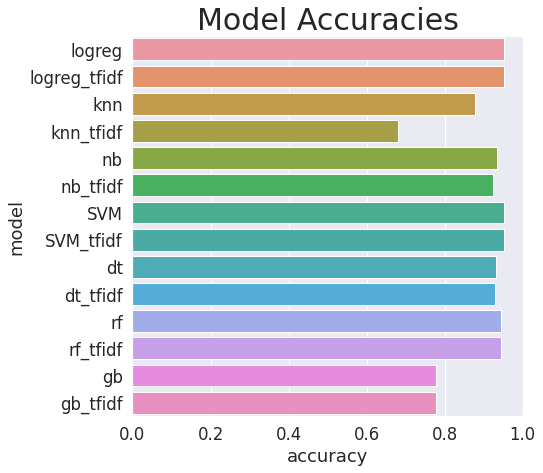

In [ ]:
# plot
plt.figure(figsize=(7,7))
sns.set(font_scale = 1.5)
sns.barplot(x="accuracy", y="model", data=ACCs)
plt.title("Model Accuracies", size = 30)

# 4. Model implementation and tuning (25 marks):

Train models on the training data and apply the model to the test data to obtain an accuracy value. Perform hyperparameter tuning and cross-validation, if necessary. <- **this part has been done above.**

Part 1 -  Evaluate the same model with **best performance** on the 2020 US elections data. How well do your predictions match the sentiment labelled in the 2020 US elections data? 

Part 2 -  Choose the model that has the **best performance** and **visualize sentiment prediction results and the true sentiment for each of the two parties/candidates**. Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

Part 3 -  Split the **negative 2020 US elections tweets** into training data (70%) and test data (30%). Use **true sentiment labels** in the 2020 US elections data instead of your predictions from the previous part. Choose **three algorithms from classification algorithms** (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF, XGBoost)), train **multi-class classification models to predict the reason for the negative tweets**. **Tune the hyperparameters and chose the model with best score to test your prediction reason for negative sentiment tweets**. There are 5 different negative reasons labelled in the dataset.

Feel free to combine similar reasons into fewer categories as long as you justify your reasoning. You are free to define input features of your model using word frequency analysis or other techniques.

## Part 1

Evaluate the same model with **best performance** on the 2020 US elections data. How well do your predictions match the sentiment labelled in the 2020 US elections data? 

The model with the best performance on generic tweets is the logistic regression model with bag of words feature engineering.

In [ ]:
elect.head()

,text,sentiment,negative_reason,words,hashtags,party
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19,"[afraid, nov, dec, jan, #bidenharris2020, win,...",[#bidenharris2020],Democratic
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others,"[lord, sumption, launches, recovery, initiativ...","[#anotherway, #covid]",Others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19,"[uber, timing, #biden, advisors, pressure, #br...","[#biden, #brazil]",Democratic
3,b'Every 107 seconds an American is dying from ...,1,NaN,"[b'every, 107, seconds, american, dying, #trum...","[#trumpvirus, #donaldtrump, #joebiden]",Democratic
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN,"[#democrats, embrace, #diversityandinclusion, ...","[#democrats, #diversityandinclusion, #vote]",Democratic


### Bag of Words for election tweets based on the vocabulary dictionary from the generic tweets

In [30]:
# take the words in each election-related tweet as the corpus to vectorize later
corpus_elect = []

for i in range(len(elect)):
    corpus_elect.append(" ".join(elect['words'][i]))
    
X_elect = corpus_elect

In [31]:
# set sentiment in election-related tweets data as the predicted data
y_elect = list(elect['sentiment'])

In [32]:
# X_train was the training set from generic tweet data
X_train_wf = vectorizer.fit_transform(X_train)

In [33]:
# vectorize election tweet words based on the features built on the generic tweet data
X_elect_vec = vectorizer.transform(X_elect)

In [34]:
X_elect_vec

<2552x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 13822 stored elements in Compressed Sparse Row format>

In [35]:
print('Vocabulary Size: {}'.format(len(vectorizer.vocabulary_)))

Vocabulary Size: 10000


### Best model trained on generic tweets - Logistic Regression

In [ ]:
# logistic regression was the best model
# increase max_iter for _coef to converge
logreg = LogisticRegression(solver = 'lbfgs', max_iter=1000)

In [ ]:
# fit logistic regression model to training data from **generic tweets**
logreg.fit(X_train_wf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# use the logistic regression model trained on generic tweets to predict sentiment of election tweets
pred_logreg_elect = logreg.predict(X_elect_vec)
confusion = confusion_matrix(y_elect,pred_logreg_elect)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_elect,pred_logreg_elect,target_names = ['Negative','Positive']))

Confusion matrix: 
[[1170   94]
 [ 745  543]]
              precision    recall  f1-score   support

    Negative       0.61      0.93      0.74      1264
    Positive       0.85      0.42      0.56      1288

    accuracy                           0.67      2552
   macro avg       0.73      0.67      0.65      2552
weighted avg       0.73      0.67      0.65      2552



In [ ]:
accuracy_score(y_elect,pred_logreg_elect)

0.6712382445141066

Using the **best model trained on the generic tweet data**, it results in around 67.12% accuracy for predicting the sentiment classification in the US election-related tweets.

## Part 2

Choose the model that has the **best performance** and **visualize sentiment prediction results and the true sentiment for each of the two parties/candidates**. Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

In [ ]:
logreg_pred = pd.DataFrame(pred_logreg_elect, columns = ['logreg_pred'])

# save to csv in case need to rerun
logreg_pred.to_csv("logreg_pred_elect.csv")

In [ ]:
# combine prediction with the election dataframe
elect = pd.concat([elect,logreg_pred],axis=1)

In [ ]:
elect.head()

,text,sentiment,negative_reason,words,hashtags,party,logreg_pred
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19,"[afraid, nov, dec, jan, #bidenharris2020, win,...",[#bidenharris2020],Democratic,0
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others,"[lord, sumption, launches, recovery, initiativ...","[#anotherway, #covid]",Others,0
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19,"[uber, timing, #biden, advisors, pressure, #br...","[#biden, #brazil]",Democratic,0
3,b'Every 107 seconds an American is dying from ...,1,NaN,"[b'every, 107, seconds, american, dying, #trum...","[#trumpvirus, #donaldtrump, #joebiden]",Democratic,0
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN,"[#democrats, embrace, #diversityandinclusion, ...","[#democrats, #diversityandinclusion, #vote]",Democratic,1


In [ ]:
# separate tweets for Democratic and Rebublican parties
twoPartiesDF = elect[elect['party'] != 'Others']

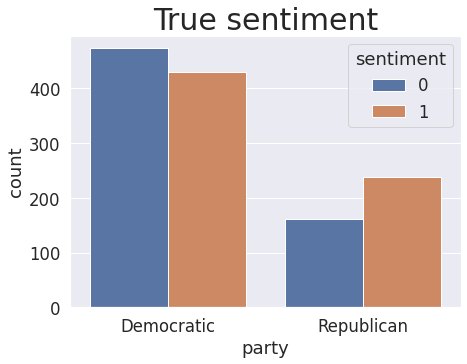

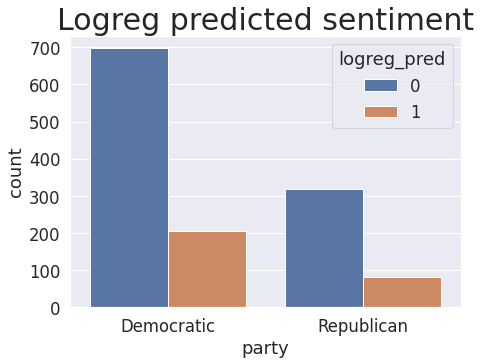

In [ ]:
# visualize true and predicted positive and negative sentiment

plt.figure(figsize=(7,5))
sns.set(font_scale = 1.5)
sns.countplot(x="party", hue="sentiment", data=twoPartiesDF)
plt.title("True sentiment", size = 30)
plt.show()

plt.figure(figsize=(7,5))
sns.set(font_scale = 1.5)
sns.countplot(x="party", hue="logreg_pred", data=twoPartiesDF)
plt.title("Logreg predicted sentiment", size = 30)
plt.show()


### Below discussion also replies to **Q5 part 1**: "Answer the research question stated above based on the outputs of your first model. Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value."


**From the true sentiment plot, we can see that:**

(1) There are a lot more tweets **supporting** Democratic party than Republican party. -> I categorized the parties based on their support instead of the mere mentioning of the parties. (see part 2) I prefer this way of categorizing political party since we can directly compare the number of support we have for each party.

(2) Tweets that are categorized as Republican supporters are mostly showing political support by saying something positive about the Republican party. 

(3) On the other hand, tweets that are categorized as Democrat supporters are mostly showing political support by criticizing the Republican party. 

-> I can infer this since I categorized negative tweets mentioning Republican-related words as Democratic supporters.


**From the sentiment predicted using model trained on generic tweet data, we can see that:**

(1) It overall predicts a lot more negative than positive sentiment. This can imply that, compared to generic tweets, election-related tweets are usually more negative sentimentally. This implication could most likely be correct since people get very critical when it comes to political topics. Moreover, given the COVID situation in the states, a lot of resentful tweets could be targeted at the parties due to the distressful pandemic.

(2) It seems like both parties' supporters conveys a lot of negative opinions toward the opponent party in support of their own party. Still, there are way more Democrat supporters criticizing Republican party than the opposite direction, just as what we saw in the true sentiment plot.

Based on what we observed above, Natural Language Processing of tweets could be very infomative about the public's opinions on each of the political party. As we can see, by doing a sentiment analysis on the tweets and classify the political supports of each tweet using a combination of the classified sentiment and hashtag or text mentioning of key words, we can have an idea of how many people are unhappy or happy about a certain political party.

By predicting sentiment of election-related tweets using models trained on generic tweets, we can infer that election-related tweets are likely more negative than the sentiment of generic tweets. This could give us clues that **the driving motive for political support could be the anger/complaints against the opponent political party instead of praises for the supported political party**. 

Specifically, from the election-related tweets, we can see that many people are unhappy about the Republican party, likely turning them into supporters of the Democratic party. This observation matches with the fact that the Democratic candidate Joe Biden won the 2020 election over the Republican candidate Donald Trump with many states flipping from Republican to Democrat.

## Part 3

Split the **negative 2020 US elections tweets** into training data (70%) and test data (30%). Use **true sentiment labels** in the 2020 US elections data instead of your predictions from the previous part. Choose **three algorithms from classification algorithms** (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF, XGBoost)), train **multi-class classification models to predict the reason for the negative tweets**. **Tune the hyperparameters and chose the model with best score to test your prediction reason for negative sentiment tweets**. There are 5 different negative reasons labelled in the dataset.

Feel free to combine similar reasons into fewer categories as long as you justify your reasoning. You are free to define input features of your model using word frequency analysis or other techniques.

In [39]:
# take only the true negative election tweets
neg_elect = elect[elect["sentiment"] == 0].reset_index(drop=True)

In [40]:
neg_elect.head()

,text,sentiment,negative_reason,words,hashtags,party
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19,"[afraid, nov, dec, jan, #bidenharris2020, win,...",[#bidenharris2020],Democratic
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others,"[lord, sumption, launches, recovery, initiativ...","[#anotherway, #covid]",Others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19,"[uber, timing, #biden, advisors, pressure, #br...","[#biden, #brazil]",Democratic
3,accelerating. &amp; rising when all #Americans...,0,discrimination,"[accelerating, rising, #americans, killed, #tr...","[#americans, #trumpvirus]",Democratic
4,b'@realDonaldTrump 961 dead Americans in one d...,0,discrimination,"[961, dead, americans, day, 240, times, number...",[],Others


In [41]:
# look at all the negative reasons
neg_elect['negative_reason'].unique()

array(['covid19', 'others', 'discrimination', 'corruption', 'crime'],
      dtype=object)

In [42]:
# take the corpus of negative election tweets
corpus_neg_elect = []

for i in range(len(neg_elect)):
    corpus_neg_elect.append(" ".join(neg_elect['words'][i]))

In [43]:
# assign X and Y variables
X_neg_elect = corpus_neg_elect
Y_neg_elect = list(neg_elect['negative_reason'])

In [98]:
# split x and y var into train and test
X_train, X_test, y_train, y_test = train_test_split(X_neg_elect, Y_neg_elect, test_size=0.3, random_state=42)

In [99]:
# vectorizer for bag of words
vectorizer = CountVectorizer()

In [100]:
# build the bags of words on tain and test set
X_train_wf = vectorizer.fit_transform(X_train)
X_test_wf = vectorizer.transform(X_test)

In [101]:
X_train_wf

<884x3015 sparse matrix of type '<class 'numpy.int64'>'
	with 6926 stored elements in Compressed Sparse Row format>

In [102]:
X_test_wf

<380x3015 sparse matrix of type '<class 'numpy.int64'>'
	with 2162 stored elements in Compressed Sparse Row format>

Now, I will use the following three types of models to train multiclass classification models to predict negative election tweets' negative reasons:

(1) logistic regression

(2) linear SVM

(3) Decision trees


### (1) Logistic regression

The one vs all option is the sklearn logistic regression function allows us the do multiclass classification as a series of binary classification.

In [ ]:
# increase max_iter so that the _coef will converge
logreg = LogisticRegression(solver = 'saga', multi_class = 'ovr', max_iter = 1000)

In [ ]:
# fit logistic regression model to training data
logreg.fit(X_train_wf, y_train)
# look at accuracy of the model on training and test sets
print("Training set score: {:.3f}".format(logreg.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_wf, y_test)))

Training set score: 0.982
Test set score: 0.334


In [ ]:
pred_logreg_neg_elect = logreg.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_logreg_neg_elect)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_logreg_neg_elect))

Confusion matrix: 
[[17 36  5  5  3]
 [ 9 73  9  7  9]
 [10 38 12  9  5]
 [10 35  7 12  2]
 [ 5 35  9  5 13]]
                precision    recall  f1-score   support

    corruption       0.33      0.26      0.29        66
       covid19       0.34      0.68      0.45       107
         crime       0.29      0.16      0.21        74
discrimination       0.32      0.18      0.23        66
        others       0.41      0.19      0.26        67

      accuracy                           0.33       380
     macro avg       0.34      0.30      0.29       380
  weighted avg       0.33      0.33      0.30       380



In [ ]:
accuracy_score(y_test,pred_logreg_neg_elect)

0.33421052631578946

#### Hyperparameter tuning

For logistic regression, we can tune the hyperparameters: penalty, C, and multi_class method.

In [ ]:
# increase max_iter so that the _coef will converge
# i chose saga as the solver since its the only solver that takes both types of multi_class and both penalties
logreg = LogisticRegression(solver = 'saga', max_iter = 10000)

In [ ]:
#create a dictionary of all values we want to test for the hyperparameters
# solver lbfgs only support l2 penalty
param_grid = {'penalty': ['l1','l2'],
              'C': [0.001,0.01,0.1,10,100,1000],
              'multi_class': ['ovr','multinomial']
             }

In [ ]:
logreg_gscv = GridSearchCV(logreg, param_grid = param_grid, cv = 5)

In [ ]:
#fit model to data
logreg_gscv.fit(X_train_wf, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 10, 100, 1000],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
#check top performing hyperparameter values
print("Best parameters: \n{}".format(logreg_gscv.best_params_))
#check mean score for the top performing value of n_neighbors
print("Best score: \n{}".format(logreg_gscv.best_score_))

Best parameters: 
{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2'}
Best score: 
0.342725988700565


### (2) Support vector machine (SVM)


In [55]:
from sklearn import svm

In [ ]:
# Create a svm Classifier
# The multiclass support is handled according to a one-vs-one scheme.

SVM = svm.SVC(kernel='linear')

In [ ]:
#Train the model using the training sets
SVM.fit(X_train_wf, y_train)

print("Training set score: {:.3f}".format(SVM.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(SVM.score(X_test_wf, y_test)))

Training set score: 0.985
Test set score: 0.318


In [ ]:
pred_SVM_neg_elect = SVM.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_SVM_neg_elect)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_SVM_neg_elect))

Confusion matrix: 
[[21 33  4  5  3]
 [16 55 11 15 10]
 [11 32 14 10  7]
 [14 27  6 15  4]
 [ 8 29  8  6 16]]
                precision    recall  f1-score   support

    corruption       0.30      0.32      0.31        66
       covid19       0.31      0.51      0.39       107
         crime       0.33      0.19      0.24        74
discrimination       0.29      0.23      0.26        66
        others       0.40      0.24      0.30        67

      accuracy                           0.32       380
     macro avg       0.33      0.30      0.30       380
  weighted avg       0.33      0.32      0.31       380



In [ ]:
accuracy_score(y_test,pred_SVM_neg_elect)

0.31842105263157894

#### Hyperparameter tuning

For linear SVM, we can tune the hyperparameters: kernel and C.

In [ ]:
SVM = svm.SVC()

In [ ]:
#create a dictionary of all values we want to test for the hyperparameters
param_grid = {'kernel': ['linear', 'rbf', 'poly'],
              'C': [0.001,0.01,0.1,10,100,1000]
             }

In [ ]:
SVM_gscv = GridSearchCV(SVM, param_grid = param_grid, cv = 5)

In [ ]:
#fit model to data
SVM_gscv.fit(X_train_wf, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 10, 100, 1000],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
#check top performing hyperparameter values
print("Best parameters: \n{}".format(SVM_gscv.best_params_))
#check mean score for the top performing value of n_neighbors
print("Best score: \n{}".format(SVM_gscv.best_score_))

Best parameters: 
{'C': 10, 'kernel': 'poly'}
Best score: 
0.37894196199280944


### (3) Decision tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

In [ ]:
#Train the model using the training sets
dt.fit(X_train_wf, y_train)

print("Training set score: {:.3f}".format(dt.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(dt.score(X_test_wf, y_test)))

Training set score: 0.989
Test set score: 0.321


In [ ]:
pred_dt_neg_elect = dt.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_dt_neg_elect)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_dt_neg_elect))

Confusion matrix: 
[[16 32  5  7  6]
 [ 7 65 15  7 13]
 [ 6 35 12  8 13]
 [11 32  5 13  5]
 [ 5 31  5 10 16]]
                precision    recall  f1-score   support

    corruption       0.36      0.24      0.29        66
       covid19       0.33      0.61      0.43       107
         crime       0.29      0.16      0.21        74
discrimination       0.29      0.20      0.23        66
        others       0.30      0.24      0.27        67

      accuracy                           0.32       380
     macro avg       0.31      0.29      0.29       380
  weighted avg       0.31      0.32      0.30       380



In [ ]:
accuracy_score(y_test,pred_dt_neg_elect)

0.32105263157894737

#### Hyperparameter tuning

For decision tree, we can tune the hyperparameters: criterion, max_depth, min_samples_split, min_samples_leaf

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1,1000, 99),
              'min_samples_split': range(2,10),
              'min_samples_leaf': range(1,10)
             }

In [ ]:
dt_gscv = GridSearchCV(dt, param_grid = param_grid, cv = 5)

In [ ]:
#fit model to data
dt_gscv.fit(X_train_wf, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [ ]:
#check top performing hyperparameter values
print("Best parameters: \n{}".format(dt_gscv.best_params_))
#check mean score for the top performing value of n_neighbors
print("Best score: \n{}".format(dt_gscv.best_score_))

Best parameters: 
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best score: 
0.3483949666153056


### Using best model to predict test set
From the above three multiclass classifiers, through hyperparemeter tuning, the model with the best performance (highest accuracy of around 38%) is support vector machine (SVM) with polynomial kernel and C = 10.

In [56]:
SVM_best = svm.SVC(C = 10, kernel = 'poly')

In [57]:
# fit to train data
SVM_best.fit(X_train_wf, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [58]:
# see the model's prediction on test set
pred_SVM_best = SVM_best.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_SVM_best)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_SVM_best))

Confusion matrix: 
[[  9  57   0   0   0]
 [  0 102   2   2   1]
 [  1  65   8   0   0]
 [  2  54   0  10   0]
 [  0  58   1   0   8]]
                precision    recall  f1-score   support

    corruption       0.75      0.14      0.23        66
       covid19       0.30      0.95      0.46       107
         crime       0.73      0.11      0.19        74
discrimination       0.83      0.15      0.26        66
        others       0.89      0.12      0.21        67

      accuracy                           0.36       380
     macro avg       0.70      0.29      0.27       380
  weighted avg       0.66      0.36      0.29       380



In [59]:
accuracy_score(y_test,pred_SVM_best)

0.3605263157894737

The best classification model (SVM) from hyperparameter tuning got 36.05% accuracy on the test data in predicting negative election tweets' negative reasons.

# 5. Results (25 marks):

Part 1 - Answer the research question stated above based on the outputs of your first model. Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value. 


Part 2 - For the second model, based on the model that worked best, **provide a few reasons why your model may fail to predict the correct negative reasons**. Back up your reasoning **with examples from the test sets**. 


Part 3 - For **both models**, **suggest one way you can improve** the accuracy of your models.


## Part 1 has already been discussed under Q4 Part 2

## Part 2

Q: For the second model, based on the model that worked best, **provide a few reasons why your model may fail to predict the correct negative reasons**. Back up your reasoning **with examples from the test sets**. 

Ans: 

The second model, support vector mechine model using polynominal kernel and C for 10, yielded an accuracy of around 38% on prediecting the negative reasons for the negative US election tweets. There are a few possible factors contributing to the low accuracy on test set prediction:

We saw that the model prediction on training set is about 99% while the highest test set prediction accuracy can only get to around 38%. It means that the model is overfitted to the training data and does not generalize well to any unseen data (test set). 

Possible reasons behind the overfitting of the data are:

**(1) Not enough data points learned by the model:**
    
Since we have 5 different predicted classes for negative reason, we would most likely need more data points for the model to learn enough clues for each of the negative reasons. In our case, we have 5 classes but only 884 observations (tweets) in the training set.





In [49]:
# look at the size of observations we have
len(X_train)

884

In [50]:
# number of tweets for each negative reasons
train = pd.DataFrame({'X_train': X_train, 'y_train': y_train})
train.groupby('y_train').size()

y_train
corruption        154
covid19           298
crime             148
discrimination    149
others            135
dtype: int64

The model only had around 150 samples (at most 298 samples) to learn words in each category. This is very likely not enough data to have a well-performing model.

**(2) The distribution of the 5 negative reasons are imbalanced within the training dataset:**

From below, we can see that 'covid19' accounts for around 34% of the training data while the other negative reasons only account for around 17% each. The result of this imbalanced distribution of negative reasons (predicted classes) can be observed in the confusion matrix and the classification report of the second model (SVM with the best hyperparameters).

From the classification report of the second model, we can see that the precision of predicting the negative reason as 'covid19' is very low (0.3) compared to other negative reasons (~0.7-0.8). Precision indicates the proportion of positive identifications that was actually correct. Therefore, a low precision score in our case means that the model tends to classify many tweets' negative reason in the test set as 'covid19' while the true reason is not. The is the undesirable result of feeding the model more examples for 'covid19' class than the other classes.


In [51]:
print('covid: {:.2f}%'.format(y_train.count('covid19')/len(X_train)*100))
print('corruption: {:.2f}%'.format(y_train.count('corruption')/len(X_train)))
print('crime: {:.2f}%'.format(y_train.count('crime')/len(X_train)))
print('discrimination: {:.2f}%'.format(y_train.count('discrimination')/len(X_train)))
print('others: {:.2f}%'.format(y_train.count('others')/len(X_train)))

covid: 33.71%
corruption: 0.17%
crime: 0.17%
discrimination: 0.17%
others: 0.15%


In [60]:
# see the model's prediction on test set
pred_SVM_best = SVM_best.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_SVM_best)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_SVM_best))

Confusion matrix: 
[[  9  57   0   0   0]
 [  0 102   2   2   1]
 [  1  65   8   0   0]
 [  2  54   0  10   0]
 [  0  58   1   0   8]]
                precision    recall  f1-score   support

    corruption       0.75      0.14      0.23        66
       covid19       0.30      0.95      0.46       107
         crime       0.73      0.11      0.19        74
discrimination       0.83      0.15      0.26        66
        others       0.89      0.12      0.21        67

      accuracy                           0.36       380
     macro avg       0.70      0.29      0.27       380
  weighted avg       0.66      0.36      0.29       380



In [61]:
## see how many tweets in the test set were wrongly classified as 'covid19'
test = pd.DataFrame({'X_test': X_test, 'y_test': y_test, 'pred': pred_SVM_best})

test_wrong = test[test['y_test'] != test['pred']]
print('Wrongly classified as covid19: {:.2f}%'.format(len(test_wrong['pred'] == 'covid')/len(y_test)*100))


Wrongly classified as covid19: 63.95%


Supporting the discussion above, almost 64% of the tweets in the test set were wrongly classified as 'covid19'.


**(3) The classification of negative reasons are irregular (inconsistent) across tweets:**

Another possible reason why the model prediction is low could simply be because the classification of the negative reasons doesn't make sense. 

Below are some examples of the tweets classified as different negative reasons. It is concerning that we can see some tweets mentioning words like 'corrup' classified as 'covid', some tweets mentioning 'covid'-related words classified as 'crime', 'discrimination', and 'corruption'.

It seems like the true negative reasons were classified rather randomly. Many of the classification simply seems wrong. This kind of messy labeling at the first place can result in the model not being able to find rules (lists of words) tied to one classification but not the others. This could be a classic garbage in garbage out kind of case here.

In [62]:
# tweets originally classified as 'covid' negative reason
covid = test[test['y_test'] == 'covid19']
print(covid['X_test'][378])

corrupt manipulation expect democracy head usps face


In [63]:
# tweets originally classified as 'crime' negativie reason
crime = test[test['y_test'] == 'crime']
print(crime['X_test'][5])
print(crime['X_test'][22])

b'belgium hit worst #coronavirus outbreaks europe reimposed tight strict lockdown rules
#coronavirus cases soaring #covid19 1,000 americans died


In [64]:
disc = test[test['y_test'] == 'discrimination']
print(disc['X_test'][1])

killing animals killing #covidiots #covid19 #covid19uk #covid


In [65]:
corrup = test[test['y_test'] == 'corruption']
print(corrup['X_test'][4])
print(corrup['X_test'][17])

pisses negating impact covid throw cancer
insults floridians slow #covid-19 spread wait


### **Bonus** model training

Another possible reason to the low prediction accuracy could be that model type I chose to train the classification model is not getting the best out of the data. Let's try an ensemble model (random forest) and see if prediction accuracy on test set is higher than the best second model (SVM model).

### Random forest model on predicting election tweet negative reasons


In [66]:
# use default setting for all
rf = RandomForestClassifier()

In [67]:
#Train the model using the training sets 
rf.fit(X_train_wf,y_train)

print("Training set score: {:.3f}".format(rf.score(X_train_wf, y_train)))
print("Test set score: {:.3f}".format(rf.score(X_test_wf, y_test)))

Training set score: 0.989
Test set score: 0.363


In [68]:
pred_rf_neg_elect = rf.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_rf_neg_elect)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_rf_neg_elect,target_names = ['covid19', 'others', 'discrimination', 'corruption', 'crime']))

Confusion matrix: 
[[12 49  1  3  1]
 [ 4 95  2  3  3]
 [ 1 56 10  3  4]
 [ 5 49  0 12  0]
 [ 0 54  2  2  9]]
                precision    recall  f1-score   support

       covid19       0.55      0.18      0.27        66
        others       0.31      0.89      0.46       107
discrimination       0.67      0.14      0.22        74
    corruption       0.52      0.18      0.27        66
         crime       0.53      0.13      0.21        67

      accuracy                           0.36       380
     macro avg       0.52      0.30      0.29       380
  weighted avg       0.50      0.36      0.31       380



In [69]:
accuracy_score(y_test,pred_rf_neg_elect)

0.3631578947368421

#### Hyperparameter tuning

For random forest multiclass classification, we can tune the hyperparameters: n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf.

In [70]:
rf = RandomForestClassifier()

In [71]:
param_grid = {'n_estimators': range(50,300,50),
              'criterion': ['gini', 'entropy'],
              'max_depth': range(1,1000, 99),
              'min_samples_split': range(2,10),
              'min_samples_leaf': range(1,10)
             }

In [72]:
rf_gscv = GridSearchCV(rf, param_grid = param_grid, cv = 5)

In [73]:
#fit model to data
rf_gscv.fit(X_train_wf, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [74]:
#check top performing hyperparameter values
print("Best parameters: \n{}".format(rf_gscv.best_params_))
#check mean score for the top performing value of n_neighbors
print("Best score: \n{}".format(rf_gscv.best_score_))

Best parameters: 
{'criterion': 'entropy', 'max_depth': 397, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best score: 
0.38345531587057013


Here, we can see that using random forest to train our model and tune the hyperparemeters did increase the test set prediction accuracy beyond the best score we got from the previous three model types (logistic regression, SVM, and random forest). 

Now, use the random forest classifier with the best parameters to predict the test set.

In [103]:
rf_best = RandomForestClassifier(criterion='entropy',max_depth=397,min_samples_leaf=1,min_samples_split=5, n_estimators=150)

In [104]:
rf_best.fit(X_train_wf, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=397, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [105]:
# see the model's prediction on test set
pred_rf_best = rf_best.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_rf_best)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_rf_best))

Confusion matrix: 
[[ 13  50   1   1   1]
 [  1 102   1   2   1]
 [  1  59   8   3   3]
 [  4  52   0  10   0]
 [  0  54   2   2   9]]
                precision    recall  f1-score   support

    corruption       0.68      0.20      0.31        66
       covid19       0.32      0.95      0.48       107
         crime       0.67      0.11      0.19        74
discrimination       0.56      0.15      0.24        66
        others       0.64      0.13      0.22        67

      accuracy                           0.37       380
     macro avg       0.57      0.31      0.29       380
  weighted avg       0.55      0.37      0.31       380



In [106]:
accuracy_score(y_test,pred_rf_best)

0.3736842105263158

Prediction on test set slightly improved from 36.05% (SVM) to 37.37%.

## Part 3

For **both models**, **suggest one way you can improve the accuracy** of your models.

Model 1 

(1) Since the model that was used to predict the election tweets sentiment was trained on the generic tweets, many election-related words may not be learned by the model. Therefore, we can try training the model on a training set of the US election tweets instead of the generic tweets to predict sentiment of election tweets. (see below bonus validation)

(2) Another possible way to improve the model is to tune the hyperparameters of the model and find the combination of hyperparameters that give the best accuracy in the cross-validation process.


Model 2 

One way to potentially improve the model is to change the feature engineering method. For example, we can try using n-gram to include bi- and tri-grams. Other than N-gram, we can also try lemmatization or use a different feature engineering method such as TF-IDF for the feature engineering. It seems like the prevalence of the term covid is a confusing element for the model to learn the differentiation between classes. TF-IDF method may help minimizing the importance of the term 'covid' since it appears in a large proportion of the tweets. (see below bonus validation)

### **Bonus** validation of my suggestions to improve models

#### For model 1:
 (1)
Instead of using the model trained on generic tweets to predict election tweet sentiment, we can split the election tweets into train and test sets and train the logistic regression model on the election train set and predict the test set sentiment.

In [79]:
# take the words in each election-related tweet as the corpus to vectorize later
corpus_elect = []

for i in range(len(elect)):
    corpus_elect.append(" ".join(elect['words'][i]))
    
X_elect = corpus_elect

In [80]:
# set sentiment in election-related tweets data as the predicted data
y_elect = list(elect['sentiment'])

In [81]:
# splitting into train and testing
X_train, X_test, y_train, y_test = train_test_split(X_elect, y_elect, test_size=0.3, random_state=42)

In [82]:
X_train_wf = vectorizer.fit_transform(X_train)
X_test_wf = vectorizer.transform(X_test)

In [83]:
X_train_wf

<1786x4812 sparse matrix of type '<class 'numpy.int64'>'
	with 13213 stored elements in Compressed Sparse Row format>

In [84]:
print('Vocabulary Size: {}'.format(len(vectorizer.vocabulary_)))

Vocabulary Size: 4812


In [85]:
# logistic regression was the best model
logreg = LogisticRegression(solver = 'lbfgs')

In [86]:
# fit logistic regression model to training data from **generic tweets**
logreg.fit(X_train_wf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [87]:
# use the logistic regression model trained on generic tweets to predict sentiment of election tweets
pred_logreg_elect = logreg.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_logreg_elect)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_logreg_elect,target_names = ['Negative','Positive']))

Confusion matrix: 
[[278 111]
 [ 65 312]]
              precision    recall  f1-score   support

    Negative       0.81      0.71      0.76       389
    Positive       0.74      0.83      0.78       377

    accuracy                           0.77       766
   macro avg       0.77      0.77      0.77       766
weighted avg       0.77      0.77      0.77       766



In [88]:
accuracy_score(y_test,pred_logreg_elect)

0.7702349869451697

Here, we can see that by training the model on election tweet data instead of generic data, the model's prediction on election tweet sentiment impoved from the previous 67% to 77%.

#### For model 2:

Try TF-IDF feature engineering instead of bag of words.

In [107]:
# take the corpus of negative election tweets
corpus_neg_elect = []

for i in range(len(neg_elect)):
    corpus_neg_elect.append(" ".join(neg_elect['words'][i]))

In [124]:
# assign X and Y variables
X_neg_elect = corpus_neg_elect
Y_neg_elect = list(neg_elect['negative_reason'])

In [125]:
# split x and y var into train and test
X_train, X_test, y_train, y_test = train_test_split(X_neg_elect, Y_neg_elect, test_size=0.3, random_state=42)

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
# taking unigrams only
tfidf = TfidfVectorizer(ngram_range=(1,1))

In [127]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [128]:
SVM_best = svm.SVC(C = 10, kernel = 'poly')

In [129]:
# fit to train data
SVM_best.fit(X_train_tfidf, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [130]:
# see the model's prediction on test set
pred_SVM_best = SVM_best.predict(X_test_tfidf)
confusion = confusion_matrix(y_test,pred_SVM_best)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_SVM_best))

Confusion matrix: 
[[  9  57   0   0   0]
 [  0 105   1   0   1]
 [  2  64   8   0   0]
 [  0  56   0  10   0]
 [  0  57   1   1   8]]
                precision    recall  f1-score   support

    corruption       0.82      0.14      0.23        66
       covid19       0.31      0.98      0.47       107
         crime       0.80      0.11      0.19        74
discrimination       0.91      0.15      0.26        66
        others       0.89      0.12      0.21        67

      accuracy                           0.37       380
     macro avg       0.75      0.30      0.27       380
  weighted avg       0.70      0.37      0.29       380



In [131]:
accuracy_score(y_test,pred_SVM_best)

0.3684210526315789

It seems like TD-IDF feature engineering did slightly help in improving the model accuracy (from 36.05% to 36.84%).

Now, let's try including bi-grams and tri-grams in TD-IDF feature engineering and see if accuracy improves further.

In [138]:
# taking unigrams, bigrams, and trigrams
tfidf = TfidfVectorizer(ngram_range=(1,3))

In [139]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [140]:
SVM_best = svm.SVC(C = 10, kernel = 'poly')

In [141]:
# fit to train data
SVM_best.fit(X_train_tfidf, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [142]:
# see the model's prediction on test set
pred_SVM_best = SVM_best.predict(X_test_tfidf)
confusion = confusion_matrix(y_test,pred_SVM_best)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_SVM_best))

Confusion matrix: 
[[  8  58   0   0   0]
 [  0 105   1   0   1]
 [  1  65   8   0   0]
 [  0  56   0  10   0]
 [  0  58   1   0   8]]
                precision    recall  f1-score   support

    corruption       0.89      0.12      0.21        66
       covid19       0.31      0.98      0.47       107
         crime       0.80      0.11      0.19        74
discrimination       1.00      0.15      0.26        66
        others       0.89      0.12      0.21        67

      accuracy                           0.37       380
     macro avg       0.78      0.30      0.27       380
  weighted avg       0.73      0.37      0.29       380



In [143]:
accuracy_score(y_test,pred_SVM_best)

0.36578947368421055

Including bi- and tri- grams doesn't seem to further improved the model with TF-IDF feature engineering. Let's see if N-grams would help the bag-of-words (the original engineering) version of the model.

In [144]:
# take the corpus of negative election tweets
corpus_neg_elect = []

for i in range(len(neg_elect)):
    corpus_neg_elect.append(" ".join(neg_elect['words'][i]))

In [145]:
# assign X and Y variables
X_neg_elect = corpus_neg_elect
Y_neg_elect = list(neg_elect['negative_reason'])

In [146]:
# split x and y var into train and test
X_train, X_test, y_train, y_test = train_test_split(X_neg_elect, Y_neg_elect, test_size=0.3, random_state=42)

In [148]:
# taking 1-3 grams 
wf = CountVectorizer(ngram_range=(1,3))


In [149]:
X_train_wf = wf.fit_transform(X_train)
X_test_wf = wf.transform(X_test)

In [150]:
SVM_best = svm.SVC(C = 10, kernel = 'poly')

In [151]:
# fit to train data
SVM_best.fit(X_train_wf, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [152]:
# see the model's prediction on test set
pred_SVM_best = SVM_best.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_SVM_best)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_SVM_best))

Confusion matrix: 
[[  7  59   0   0   0]
 [  0 105   1   0   1]
 [  1  65   8   0   0]
 [  0  56   0  10   0]
 [  0  58   1   0   8]]
                precision    recall  f1-score   support

    corruption       0.88      0.11      0.19        66
       covid19       0.31      0.98      0.47       107
         crime       0.80      0.11      0.19        74
discrimination       1.00      0.15      0.26        66
        others       0.89      0.12      0.21        67

      accuracy                           0.36       380
     macro avg       0.77      0.29      0.26       380
  weighted avg       0.72      0.36      0.28       380



In [153]:
accuracy_score(y_test,pred_SVM_best)

0.3631578947368421

It seems like including bi- and tri- grams in the model also slightly helped to improve the original model from 36.05% to 36.32%.

Now let's try lemmetization on the tokenized words to see if these can help improving the model.

In [187]:
# take words from negative tweets
tokens = ""
for i in range(0,len(neg_elect)):
  tokens += " ".join(neg_elect['words'][i])

In [188]:
# use nltk packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
remv = nltk.RegexpTokenizer(r"\w+")
tokenization = remv.tokenize(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [189]:
lem_words = []

for i in range(0,len(tokenization)):
  lem_words.append(wordnet_lemmatizer.lemmatize(tokenization[i]))

In [200]:
# take the corpus of lemmatized words
corpus_neg_elect = []

for i in range(len(neg_elect)):
    corpus_neg_elect.append("".join(lem_words[i]))

In [209]:
# assign X and Y variables
X_neg_elect = corpus_neg_elect
Y_neg_elect = list(neg_elect['negative_reason'])

In [210]:
# split x and y var into train and test
X_train, X_test, y_train, y_test = train_test_split(X_neg_elect, Y_neg_elect, test_size=0.3, random_state=42)

In [211]:
# taking 1-3 grams 
wf = CountVectorizer(ngram_range=(1,3))


In [212]:
X_train_wf = wf.fit_transform(X_train)
X_test_wf = wf.transform(X_test)

In [213]:
SVM_best = svm.SVC(C = 10, kernel = 'poly')

In [214]:
# fit to train data
SVM_best.fit(X_train_wf, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [215]:
# see the model's prediction on test set
pred_SVM_best = SVM_best.predict(X_test_wf)
confusion = confusion_matrix(y_test,pred_SVM_best)
print("Confusion matrix: \n{}".format(confusion))
print(classification_report(y_test,pred_SVM_best))

Confusion matrix: 
[[ 2 55  3  3  3]
 [ 4 86  5  9  3]
 [ 3 62  3  3  3]
 [ 1 56  5  4  0]
 [ 3 51  2  6  5]]
                precision    recall  f1-score   support

    corruption       0.15      0.03      0.05        66
       covid19       0.28      0.80      0.41       107
         crime       0.17      0.04      0.07        74
discrimination       0.16      0.06      0.09        66
        others       0.36      0.07      0.12        67

      accuracy                           0.26       380
     macro avg       0.22      0.20      0.15       380
  weighted avg       0.23      0.26      0.17       380



In [216]:
accuracy_score(y_test,pred_SVM_best)

0.2631578947368421

It seems like lemmetization of the words decreased the model accuracy. This could be because I am using the best parameters tuned according on the model with non-lemmetized words. Re-tune the hyperparameter with the lemmetized words should be able to improve the model performance. Moreover, the process of lemmetization basically combines words having the same lemma; thus, it decreases the number of words vectorized. It could be that the variants of the same lemma actually tells us something about the different negative reasons (this reason may be unlikely but still possible). Or it could also be because of the bad labeling of negative reasons as discussed earlier, making a model with less vectorized words even harder to predict the messy classification of negative reasosn.